# Imports

In [ ]:
!pip install transformers
!pip install sentence_transformers
!pip install datasets
!pip install sentencepiece
!pip install scikit-learn-extra
!pip install wikipedia
!pip install eli5
!pip install lime


     |████████████████████████████████| 2.3MB 16.9MB/s 
     |████████████████████████████████| 901kB 47.1MB/s 
     |████████████████████████████████| 3.3MB 42.5MB/s 
     |████████████████████████████████| 81kB 5.6MB/s 
     |████████████████████████████████| 1.2MB 30.6MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.2.0-cp37-none-any.whl size=123339 sha256=30f7bd88e9a8ef80b5b7c56c6ac2f890d9561c7afd7ea776f94ddea8d640b2c8
  Stored in directory: /root/.cache/pip/wheels/0f/06/f7/faaa96fdda87462b4fd5c47b343340e9d5531ef70d0eef8242
Successfully built sentence-transformers
     |████████████████████████████████| 225kB 15.0MB/s 
     |████████████████████████████████| 245kB 23.0MB/s 
     |████████████████████████████████| 112kB 31.6MB/s 
     |████████████████████████████████| 1.7MB 14.1MB/s 
     |████████████████████████████████| 22.3MB 1.2MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Succe

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import argparse
from __future__ import print_function
from collections import Counter
import string
import re
import argparse
import json
import os
import random
import shutil
import lime
import lime.lime_tabular
import wikipedia
import time
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from tqdm import tqdm
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
from PIL import Image
import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity
import sys
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.gaussian_process.kernels import RBF
import torch
from sklearn.metrics.pairwise import rbf_kernel

from scipy.stats import multivariate_normal
import  scipy.stats as st
from matplotlib import cm
import torch.optim as optim
from __future__ import print_function
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, AdamW, AutoModel
import nltk
from torch.utils.data import DataLoader
import pickle
import spacy
from gensim import corpora, models, similarities
import gensim
from spacy.lang.en import English
from nltk.corpus import wordnet as wn
from sklearn.metrics.pairwise import rbf_kernel
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.cluster import KMeans
import pickle
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
import matplotlib
from sklearn.metrics.pairwise import rbf_kernel
import copy
import eli5
from eli5.lime import TextExplainer
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')

cpu
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# HotpotQA


In [ ]:
from datasets import load_dataset
DISTRACTORS_PARS_LEN = 0
dataset = load_dataset("hotpot_qa", 'distractor')
train_dataset = dataset['train']
validation_dataset = dataset['validation']

Dataset hotpot_qa downloaded and prepared to /root/.cache/huggingface/datasets/hotpot_qa/distractor/1.0.0/133b9501f892e5193babbad937bee3b4899deb4691ef4d791e6ac0111c875bb5. Subsequent calls will reuse this data.


In [ ]:
def get_token_lenght(context, question):
    inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt")
    return len(inputs['input_ids'][0])

def remove_distractors(example, n_distractors = 0):
    all_pars = example['context']['title']
    gold_pars = list(set(example['supporting_facts']['title']))
    distractor_pars = list(set(all_pars) - set(gold_pars))
    # get indices to keep from disractors
    if len(distractor_pars) == 0 or n_distractors == 0:
        distract_indices = []
    else:
        distract_indices = random.sample(range(len(distractor_pars)), n_distractors)
    distractor_pars = [distractor_pars[idx] for idx in distract_indices]
    keep_pars = gold_pars + distractor_pars
    keep_pars_indices = [all_pars.index(keep_par) for keep_par in keep_pars]
    example['context']['title'] = [example['context']['title'][idx] for idx in keep_pars_indices]
    example['context']['sentences'] = [example['context']['sentences'][idx] for idx in keep_pars_indices]
    
    sentences_par = ["".join(example['context']['sentences'][idx]) for idx in range(len(example['context']['sentences']))]
    example['intros'] = " ".join([example['context']['sentences'][idx][0] for idx in range(len(example['context']['sentences']))])
    example['passage'] = " #$ ".join(sentences_par)
    return example



In [ ]:
train_dataset = train_dataset.map(remove_distractors)
validation_dataset = validation_dataset.map(remove_distractors)

In [ ]:
# Free form vs yes/no
all_indices = set(list(range(len(validation_dataset))))
yes_no_indices = set([i  for i in range(len(validation_dataset)) if validation_dataset[i]['answer'] in ["yes","no"] ])
free_indices_val = all_indices - yes_no_indices
all_indices = set(list(range(len(train_dataset))))
yes_no_indices_train = set([i  for i in range(len(train_dataset)) if (train_dataset[i]['answer'] in ["yes","no"]) or (train_dataset[i]['level'] in ['easy','medium']) ])
free_indices_train = all_indices - yes_no_indices_train
print(len(free_indices_val))
print(len(free_indices_train))


6947
14631


In [ ]:
hard_dataset = [train_dataset[i] for i in free_indices_train ]
hard_dataset += [validation_dataset[i] for i in free_indices_val]
dataset_indices =  set(list(range(len(hard_dataset))))
VAL_START = len([train_dataset[i] for i in free_indices_train ])
len(hard_dataset)

21578

## Utils

In [ ]:

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))


def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)



def evaluate_truth_pred(truths, preds):
    '''
    truths, preds: matched arrays of ground truth answers and predictions
    '''
    f1 = exact_match = total = 0
    for i in range(len(truths)):
        total += 1
        if truths[i] in ['yes', "no"]:
            continue
        ground_truths = [truths[i]]
        prediction = preds[i]
        exact_match += metric_max_over_ground_truths(
            exact_match_score, prediction, ground_truths)
        f1 += metric_max_over_ground_truths(
            f1_score, prediction, ground_truths)

    exact_match = 100.0 * exact_match / (total+ 0.00000000001)
    f1 = 100.0 * f1 / (total+ 0.00000000001)

    return {'exact_match': exact_match, 'f1': f1}


def get_answer( model, tokenizer, context, question):
    # 1. TOKENIZE THE INPUT
    # note: if you don't include return_tensors='pt' you'll get a list of lists which is easier for
    # exploration but you cannot feed that into a model.
    inputs = tokenizer.encode_plus(question, context, return_tensors="pt")
    inputs = inputs.to(device)
    # 2. OBTAIN MODEL SCORES
    # the AutoModelForQuestionAnswering class includes a span predictor on top of the model.
    # the model returns answer start and end scores for each word in the text
    answer_start_scores, answer_end_scores = model(**inputs, return_dict=False)
    answer_start = torch.argmax(answer_start_scores)  # get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # get the most likely end of answer with the argmax of the score
    # 3. GET THE ANSWER SPAN
    # once we have the most likely start and end tokens, we grab all the tokens between them
    # and convert tokens back to words!
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][answer_start:answer_end]))
    return answer
# https://huggingface.co/transformers/migration.html
def model_evaluation(model, tokenizer, questions, contexts, answers, to_print = False):
    preds = []
    my_list = list(range(len(questions)))
    with tqdm(total=len(my_list)) as pbar:
        for ex in range(len(questions)):
            answer = get_answer(model, tokenizer, contexts[ex],questions[ex])
            preds.append(answer)
            if ex % 100 == 0 and to_print:
                print("context " +contexts[ex] )
                print("quest " +questions[ex] )
                print("truth " +answers[ex]['text'] )
                print("pred " + answer)
            pbar.update(1)
    truths = [answers[i]['text'] for i in range(len(answers))]
    scores = evaluate_truth_pred(truths, preds)
    print(scores)
    return scores


def kernel_similarity(x, y):
        kernel_dist = rbf_kernel(x.reshape(1, -1),y.reshape(1, -1))
        return kernel_dist[0][0]


# FakeAI model

In [ ]:
class FakeAI:
    r"""
    FakeAI that is incorrect in random clusters in the input space
    
    Args:
        train_passages: list of embedded passages
        train_questions: list of embedded questions
        n_clus_p: number of centroids in kmeans for passages
        n_clus_q: number of centroids in kmeans for questions
        clust_err_p: clusters where AI makes error on passages
        clust_err_q: clusters where AI makes error on questions
    """
    def __init__(self, train_passages, train_questions, n_clus_p, n_clus_q, beta_params = (1,1), kmeans = None, err_p = None):
 
        self.train_passages = train_passages
        self.train_questions = train_questions
        self.n_clus_p = n_clus_p
        self.n_clus_q = n_clus_q
        if err_p == None:
            self.clust_err_p = np.random.beta(beta_params[0],beta_params[1],self.n_clus_p)
            '''
            for i in range(len(self.clust_err_p)):
                if self.clust_err_p[i] <= 0.333333:
                    self.clust_err_p[i] = 0.0
                elif self.clust_err_p[i]>=0.6666666:
                    self.clust_err_p[i] = 1.0
                else:
                    self.clust_err_p[i] = 0.5
            '''
        else:
            self.clust_err_p = err_p
        self.clust_err_q = np.random.beta(0.2,0.8,self.n_clus_p)#np.random.rand(self.n_clus_q)#/2 + 0.5
        if kmeans == None:
            self.build_kmeans()
        else:
            self.kmeans_pass = kmeans
            self.kmeans_quest = kmeans

        
    def build_kmeans(self):
        # Builds kmeans for passages and questions
        self.kmeans_quest = KMeans(n_clusters=self.n_clus_q, max_iter = 10000).fit(self.train_questions)
        self.kmeans_pass = KMeans(n_clusters=self.n_clus_p, max_iter = 100000).fit(self.train_passages)

    def predict_right_wrong(self, passages, questions):
        '''
        Args:
            passages: list of embedded passages
            questions: list of embedded questions (same size as passages)
        Returns:
            preds: binary array indicating if AI is right (1) or wrong (0)
        '''
        clusts_p = self.kmeans_pass.predict(passages)
        clusts_q = self.kmeans_quest.predict(questions)
        preds = []
        for i in range(len(clusts_p)):
            coin = random.random() # random number between [0,1]
            if coin >= self.clust_err_p[clusts_p[i]]:
                preds.append(0)
            else:
                preds.append(1)
        return preds

    def prior_rejector(self, passages, questions, epsilon_reject):
        '''
        rejector defined as : 1{prob_of_correct <= epsilon_reject}
        '''
        clusts_p = self.kmeans_pass.predict(passages)
        clusts_q = self.kmeans_quest.predict(questions)
        preds = []
        for i in range(len(clusts_p)):
            coin = random.random() # random number between [0,1]
            if  self.clust_err_p[clusts_p[i]] <= epsilon_reject:
                preds.append(1)
            else:
                preds.append(0)
        return preds

    def predict_proba(self, raw_passages):
        embed_ps = model.encode(raw_passages)
        embed_ps = [embed_ps[i] for i in range(len(embed_ps))]
        clusts_p = self.kmeans_pass.predict(embed_ps)
        preds = []
        for i in range(len(clusts_p)):
            coin = random.random() # random number between [0,1]
            if coin >= self.clust_err_p[clusts_p[i]]:
                preds.append([0.0,1.0])
            else:
                preds.append([1.0,0.0])
        return np.asarray(preds)

    def predict_proba_encoded(self, passages):
        clusts_p = self.kmeans_pass.predict(passages)
        preds = []
        for i in range(len(clusts_p)):
            coin = random.random() # random number between [0,1]
            if coin >= self.clust_err_p[clusts_p[i]]:
                preds.append([0.0,1.0])
            else:
                preds.append([1.0,0.0])
        return np.asarray(preds)


def is_a_stopword(feature, weight):
    split_words = feature.split(' ')
    for word in split_words:
        if word in stopwords:
            return False
    return True

def get_highlighted_p(ai_model, paragraph):
    '''
    from https://eli5.readthedocs.io/en/latest/tutorials/black-box-text-classifiers.html#lime-tutorial
    '''
    
    te = TextExplainer(random_state=42)
    te.fit(paragraph, ai_model.predict_proba)
    show_pred = te.show_prediction(target_names=['correct','false'], top=(8,0), feature_filter = is_a_stopword)
    correct = False
    if show_pred.data.find("y=correct") != -1:
        correct = True
    b = show_pred.data.split('<p style="margin-bottom: 2.5em; margin-top:-0.5em;">')
    to_show = '<p style="margin-bottom: 2.5em; margin-top:-0.5em;">' +b[-1]
    if not correct:
        to_show = to_show.replace("hsl(120,","hsl(0,")
    return to_show

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-distilroberta-base-v1') #distilbert-base-nli-stsb-mean-tokens
# https://www.sbert.net/docs/pretrained_models.html

# Teaching Prelims



## Human classes and utilities

In [ ]:
class HumanLearner:
    def __init__(self, kernel):
        '''
        kernel: function that takes two inputs and returns a similarity
        prior rejector: returns rejector
        '''
        self.teaching_set = []
        self.kernel = kernel
    def predict(self, xs, prior_rejector_preds, to_print = False):
        '''
        xs: expected array of inputs
        '''
        preds = []
        idx = 0
        used_posterior = 0 
        if to_print:
            print("-- Human making reject predictions --")
            with tqdm(total=len(xs)) as pbar:
                for x in xs:
                    ball_at_x = []
                    similarities = rbf_kernel(x.reshape(1,-1), np.asarray([self.teaching_set[kk][0] for kk in range(len(self.teaching_set))]))[0]
                    for i in range(len(self.teaching_set)):
                        similarity = similarities[i]
                        if similarity >=  self.teaching_set[i][2]:
                            ball_at_x.append(self.teaching_set[i])
                    if len(ball_at_x) == 0: 
                        # use prior rejector
                        preds.append(prior_rejector_preds[idx])
                    else:
                        used_posterior += 1
                        ball_similarities = rbf_kernel(x.reshape(1,-1), np.asarray([ball_at_x[kk][0] for kk in range(len(ball_at_x))]))[0]
                        normalization = np.sum([ball_similarities[i] for i in range(len(ball_at_x))])
                        score_one = np.sum([ball_similarities[i]*ball_at_x[i][1] for i in range(len(ball_at_x))])
                        pred = score_one / normalization
                        if pred >= 0.5:
                            preds.append(1)
                        else:
                            preds.append(0)
                    idx += 1
                    pbar.update(1)
        else:
            for x in xs:
                ball_at_x = []
                similarities = rbf_kernel(x.reshape(1,-1), np.asarray([self.teaching_set[kk][0] for kk in range(len(self.teaching_set))]))[0]
                for i in range(len(self.teaching_set)):
                    similarity = similarities[i]
                    if similarity >=  self.teaching_set[i][2]:
                        ball_at_x.append(self.teaching_set[i])
                if len(ball_at_x) == 0: 
                    # use prior rejector
                    preds.append(prior_rejector_preds[idx])
                else:
                    used_posterior += 1
                    ball_similarities = rbf_kernel(x.reshape(1,-1), np.asarray([ball_at_x[kk][0] for kk in range(len(ball_at_x))]))[0]
                    normalization = np.sum([ball_similarities[i] for i in range(len(ball_at_x))])
                    score_one = np.sum([ball_similarities[i]*ball_at_x[i][1] for i in range(len(ball_at_x))])
                    pred = score_one / normalization
                    if pred >= 0.5:
                        preds.append(1)
                    else:
                        preds.append(0)
                idx += 1
        if to_print:
            print(f'Used posterior {used_posterior/len(xs)*100:.2f}')
        return preds

    def add_to_teaching(self, teaching_example):
        '''
        teaching_example: (x, label, gamma)
        '''
        self.teaching_set.append(teaching_example)

    def remove_last_teaching_item(self):
        self.teaching_set = self.teaching_set[:-1]

In [ ]:
def compute_predictions_humanai(hum_preds, hum_rejector, ai_preds, data_x):
    '''
    hum_preds: array of human predictions
    ai_preds: array of AI predictions
    hum_rejector: HumanLearner
    data_x: array of inputs

    Returns array of final predictions and deferalls
    '''
    predictions = []
    with torch.no_grad():
        reject_decisions = hum_rejector(data_x)
        for i in range(len(data_x)):
            if reject_decisions[i] == 1:
                # defer
                predictions.append(ai_preds[i])
            else:
                predictions.append(hum_preds[i])
    return predictions, reject_decisions

def get_metrics(preds, truths):
    # custom for each use case
    return evaluate_truth_pred(truths, preds)

def compute_metrics(human_preds, ai_preds, reject_decisions, truths, to_print = False):
    coverage = 1 - np.sum(reject_decisions)/len(reject_decisions)
    humanai_preds = []
    human_preds_sys = []
    truths_human = []
    ai_preds_sys = []
    truths_ai = []
    for i in range(len(reject_decisions)):
        if reject_decisions[i] == 1:
            humanai_preds.append(ai_preds[i])
            ai_preds_sys.append(ai_preds[i])
            truths_ai.append(truths[i])
        else:
            humanai_preds.append(human_preds[i])
            human_preds_sys.append(human_preds[i])
            truths_human.append(truths[i])
    humanai_metrics = get_metrics(humanai_preds, truths)
    human_metrics = get_metrics(human_preds_sys, truths_human)
    ai_metrics = get_metrics(ai_preds_sys, truths_ai)
    if to_print:
        print(f'Coverage is {coverage*100:.2f}')
        print(f' metrics of system are: {humanai_metrics}')
        print(f' metrics of human are: {human_metrics}')
        print(f' metrics of AI are: {ai_metrics}')
    return coverage, humanai_metrics, human_metrics, ai_metrics

## Get predictions

In [ ]:
# Define teaching and validation
random.seed(66)
all_passages = [hard_dataset[i]['passage'] for i in range(len(hard_dataset))]
embeddings_passage = model.encode(all_passages)
embeddings_passage = [embeddings_passage[i] for i in range(len(embeddings_passage))]

all_questions = [hard_dataset[i]['question'] for i in range(len(hard_dataset))]
all_answers = [hard_dataset[i]['answer'] for i in range(len(hard_dataset))]
all_sentences =  [hard_dataset[i]['context']['sentences'] for i in range(len(hard_dataset))]

train_indices = list(range(VAL_START))
test_indices = list(range(VAL_START,len(hard_dataset)))

train_passages = [embeddings_passage[i] for i in train_indices]
#train_questions = [embeddings_question[i] for i in train_indices]
test_passages = [embeddings_passage[i] for i in test_indices]
#test_questions = [embeddings_question[i] for i in test_indices]
train_sentences = [all_sentences[i] for i in train_indices]
test_sentences = [all_sentences[i] for i in test_indices]

train_answers = [all_answers[i] for i in train_indices]
test_answers = [all_answers[i] for i in test_indices]
train_raw_passages = [all_passages[i] for i in train_indices]
test_raw_passages = [all_passages[i] for i in test_indices]
train_raw_questions= [all_questions[i] for i in train_indices]
test_raw_questions = [all_questions[i] for i in test_indices]


In [ ]:

teaching_embeddings = np.asarray([np.concatenate([train_passages[i]]) for i in range(len(train_passages))])
validation_embeddings = np.asarray([np.concatenate([test_passages[i]]) for i in range(len(test_passages))])
del embeddings_passage
del model
del train_passages
del test_passages
import gc
gc.collect()

58

In [ ]:
similarities_embeds_all = rbf_kernel(np.asarray(teaching_embeddings), np.asarray(teaching_embeddings))


In [ ]:
sorted_sims = []
print("started")
for i in range(len(similarities_embeds_all)):
    if i% 500 == 0:
        print(i)
    sorted_sim = sorted([(similarities_embeds_all[i][k], k) for k in range(len(teaching_embeddings))], key=lambda tup: tup[0])
    sorted_sims.append(np.asarray(sorted_sim))

started
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500


In [ ]:
# get optimal gammas
def get_optimal_gammas():
    optimal_gammas = []
    with tqdm(total=len(teaching_embeddings)) as pbar:
        similarities_embeds_all = rbf_kernel( np.asarray(teaching_embeddings), np.asarray(teaching_embeddings))
        for i in range(len(teaching_embeddings)):
            # get all similarities
            similarities_embeds = similarities_embeds_all[i]
            opt_defer_ex = opt_defer_teaching[i]
            opt_gamma = 1
            sorted_sim = sorted([(similarities_embeds[k], opt_defer_teaching[k]) for k in range(len(teaching_embeddings))], key=lambda tup: tup[0])
            indicess = list(range(1, len(opt_defer_teaching)))
            indicess.reverse()
            for k in indicess:
                if sorted_sim[k][1] == opt_defer_ex and sorted_sim[k- 1][1] != opt_defer_ex:
                    opt_gamma = sorted_sim[k][0]
                    break
            optimal_gammas.append(opt_gamma)
            pbar.update(1)
    return optimal_gammas

# Methods

## Selection Algorithm- consistent

In [ ]:
def get_improvement_defer(current_defer_preds, opt_defer, gammas, xs, hum_preds, coin_prob = 0.05):
    error_improvements = []
    #similarities_embeds_all = rbf_kernel(np.asarray(xs), np.asarray(xs))
    error_at_i = 0
    for i in range(len(gammas)):
        coin = random.random() # random number between [0,1]
        error_at_i = 0
        if coin >= coin_prob:
            error_improvements.append(error_at_i)
            continue
        similarities_embeds = similarities_embeds_all[i]
        for j in range(len(similarities_embeds)):
            if similarities_embeds[j] >= gammas[i]:
                f1_hum = hum_preds[j]
                f1_ai = ai_teaching_preds_b[j]
                if opt_defer[i] == 1:
                    if current_defer_preds[j] == 0:
                        error_at_i += f1_ai - f1_hum
                else:
                    if current_defer_preds[j] == 1:
                        error_at_i += f1_hum - f1_ai
        error_improvements.append(error_at_i)

        # get the ball for x
        # in this ball how many does the current defer not match the optimal
    return error_improvements

def get_greedy_gamma(i, current_defer_preds, opt_defer, gammas, xs, hum_preds):
    similarities_embeds = similarities_embeds_all[i]
    sorted_sim = sorted_sims[i]#sorted([(similarities_embeds[k], k) for k in range(len(teaching_embeddings))], key=lambda tup: tup[0])
    indicess = list(range(1, len(opt_defer)))
    indicess.reverse()
    max_improve = -1000
    gamma_value = 1
    current_improve = 0
    so_far = 0
    for j in indicess:
        if so_far >= len(indicess)*0.25:
            break
        so_far += 1
        idx = int(sorted_sim[j][1])
        #f1_hum = metric_max_over_ground_truths(f1_score, train_answers[idx], [hum_teaching_preds[idx]]) # pass as param plz
        #f1_ai = metric_max_over_ground_truths(f1_score, train_answers[idx], [ai_teaching_preds[idx]])# pass as param plz
        f1_hum = hum_preds[idx]
        f1_ai = ai_teaching_preds_b[idx]
        if opt_defer[i] == 1:
            if current_defer_preds[idx] == 0:
                current_improve += f1_ai - f1_hum
        else:
            if current_defer_preds[idx] == 1:
                current_improve += f1_hum - f1_ai

        if current_improve >= max_improve:
            max_improve = current_improve 
            gamma_value = sorted_sim[j][0]

    return max_improve, gamma_value

In [ ]:
def teach_ours(hum_preds, prior_preds, opt_defer, greedy_gamma = False, add_noise = False):
    human_learner = HumanLearner(None)
    errors = []
    data_sizes  = []
    indices_used = []
    points_chosen = []
    for itt in range(MAX_SIZE):
        print(f'New size {itt}')
        best_index = -1
        # predict with current human learner
        if itt == 0:
            preds_teach = prior_preds
        else:
            preds_teach = human_learner.predict(teaching_embeddings, prior_preds)
        error_improvements = get_improvement_defer(preds_teach, opt_defer, optimal_gammas, teaching_embeddings, hum_preds)
        best_index = np.argmax(error_improvements)
        indices_used.append(best_index) # add found element to set used
        ex_embed = teaching_embeddings[best_index]
        ex_label = opt_defer[best_index]

        if greedy_gamma:
            _, greedy_gamma = get_greedy_gamma(best_index, preds_teach, opt_defer, optimal_gammas, teaching_embeddings, hum_preds)
            if add_noise:
                gamma = greedy_gamma + (np.random.rand(1)[0])*(1-greedy_gamma)-(1-greedy_gamma)/2
            else:
                gamma = greedy_gamma 
            print(f'got improvements with max {_}')

        else:
            if add_noise:
                gamma = optimal_gammas[best_index] + (np.random.rand(1)[0])*(1-optimal_gammas[best_index])-(1-optimal_gammas[best_index])/2
            else:
                gamma =  optimal_gammas[best_index]
            print(f'got improvements with max {max(error_improvements)}')


        #gamma = optimal_gammas[best_index] # + (np.random.rand(1)[0])*(1-optimal_gammas[best_index])-(1-optimal_gammas[best_index])/2 # random choice
        human_learner.add_to_teaching([ex_embed, ex_label, gamma])

        if False and itt % 3 == 0:
            print("####### train eval " +str(itt)+ " ###########")
            preds_teach = human_learner.predict(teaching_embeddings, priorhum_teaching_preds)
            _, metrics, __, ___ = compute_metrics(hum_teaching_preds, ai_teaching_preds, preds_teach, train_answers, True)
            #errors.append(metrics)   
            print("##############################")

        if itt % PLOT_INTERVAL == 0:
            print("####### val eval " +str(itt)+ " ###########")
            preds_teach = human_learner.predict(validation_embeddings, priorhum_validation_preds)
            _, metrics, __, ___ = compute_metrics(hum_validation_preds, ai_validation_preds, preds_teach, test_answers, True)
            errors.append(metrics['exact_match'])   
            print("##############################")
    return errors, indices_used
#errors, indices_used = teach_ours(True)

## Selection double greedy

In [ ]:
import multiprocessing
from multiprocessing.dummy import Pool as ThreadPool

indicess = list(range(1, len(teaching_embeddings)))
indicess.reverse()
def get_improvement_defer_greedy(current_defer_preds, opt_defer, gammas, xs, hum_preds):

    error_improvements = []
    #similarities_embeds_all = rbf_kernel(np.asarray(xs), np.asarray(xs))
    error_at_i = 0
    found_gammas = []
    for i in range(len(opt_defer)):
        coin = random.random() # random number between [0,1]
        if coin >= 0.1:
            error_improvements.append(0.0)
            found_gammas.append(1.0)
            continue
        similarities_embeds = similarities_embeds_all[i]
        sorted_sim = sorted_sims[i]#sorted([(similarities_embeds[k], k) for k in range(len(teaching_embeddings))], key=lambda tup: tup[0])

        max_improve = -1000
        gamma_value = 1
        current_improve = 0
        so_far = 0
        for j in indicess:
            if so_far >= len(indicess)*0.25:
                break
            so_far += 1
            idx = int(sorted_sim[j][1])
            f1_hum = hum_preds[idx]
            f1_ai = ai_teaching_preds_b[idx]
            if opt_defer[i] == 1:
                if current_defer_preds[idx] == 0:
                    current_improve += f1_ai - f1_hum
            else:
                if current_defer_preds[idx] == 1:
                    current_improve += f1_hum - f1_ai

            if current_improve >= max_improve:
                max_improve = current_improve 
                gamma_value = sorted_sim[j][0]
            
        error_improvements.append(max_improve)
        found_gammas.append(gamma_value)
    return error_improvements, found_gammas


In [ ]:
def teach_ours_doublegreedy(hum_preds, prior_preds, opt_defer, add_noise = False):
    human_learner = HumanLearner(None)
    errors = []
    data_sizes  = []
    indices_used = []
    points_chosen = []
    for itt in range(MAX_SIZE):
        print(f'New size {itt}')
        best_index = -1
        # predict with current human learner
        if itt == 0:
            preds_teach = prior_preds
        else:
            preds_teach = human_learner.predict(teaching_embeddings, prior_preds)
        error_improvements, best_gammas = get_improvement_defer_greedy(preds_teach, opt_defer, optimal_gammas, teaching_embeddings, hum_preds)
        print(f'got improvements with max {max(error_improvements)}')
        best_index = np.argmax(error_improvements)
        indices_used.append(best_index) # add found element to set used
        ex_embed = teaching_embeddings[best_index]
        ex_label = opt_defer_teaching[best_index]
        greedy_gamma = best_gammas[best_index] # + (np.random.rand(1)[0])*(1-optimal_gammas[best_index])-(1-optimal_gammas[best_index])/2 # random choice
        if add_noise:
            gamma = greedy_gamma + (np.random.rand(1)[0])*(1-greedy_gamma)-(1-greedy_gamma)/2
        else:
            gamma = greedy_gamma 
        human_learner.add_to_teaching([ex_embed, ex_label, gamma])

        if False and itt % 3 == 0:
            print("####### train eval " +str(itt)+ " ###########")
            preds_teach = human_learner.predict(teaching_embeddings, priorhum_teaching_preds)
            _, metrics, __, ___ = compute_metrics(hum_teaching_preds, ai_teaching_preds, preds_teach, train_answers, True)
            #errors.append(metrics)   
            print("##############################")

        if itt % PLOT_INTERVAL == 0:
            print("####### val eval " +str(itt)+ " ###########")
            preds_teach = human_learner.predict(validation_embeddings, priorhum_validation_preds)
            _, metrics, __, ___ = compute_metrics(hum_validation_preds, ai_validation_preds, preds_teach, test_answers, True)
            errors.append(metrics['exact_match'])   
            print("##############################")
    return errors, indices_used
#errors_doublegreedy, indices_used_doublegreedy = teach_ours_doublegreedy()

## Random baseline

In [ ]:
def teach_random(greedy_gamma = False):
    human_learner_random = HumanLearner(None)
    errors_random = []
    data_sizes  = []
    indices_used_random = random.sample(list(range(len(teaching_embeddings))), MAX_SIZE) # used to take gradient steps
    points_chosen = []
    for itt in range(MAX_SIZE):
        print(f'New size {itt}')
        best_index = indices_used_random[itt]
        ex_embed = teaching_embeddings[best_index]
        ex_label = opt_defer_teaching[best_index]
        if greedy_gamma:
            if itt == 0 or first_time:
                preds_teach = priorhum_teaching_preds
                first_time = False
            else:
                preds_teach = human_learner_random.predict(teaching_embeddings, priorhum_teaching_preds)
            _, greedy_gamma = get_greedy_gamma(best_index, preds_teach, opt_defer_teaching, optimal_gammas, teaching_embeddings)
            gamma = greedy_gamma
        else:
            gamma = optimal_gammas[best_index]
        human_learner_random.add_to_teaching([ex_embed, ex_label, gamma])

        if  False and itt % 100 == 0:
            print("####### train eval " +str(itt)+ " ###########")
            preds_teach = human_learner_random.predict(teaching_embeddings, priorhum_teaching_preds)
            _, metrics, __, ___ = compute_metrics(hum_teaching_preds, ai_teaching_preds, preds_teach, train_answers, True)
            #errors_random.append(metrics)   
            print("##############################")

        if  (itt) % PLOT_INTERVAL == 0:
            print("####### val eval " +str(itt)+ " ###########")
            preds_teach = human_learner_random.predict(validation_embeddings, priorhum_validation_preds)
            _, metrics, __, ___ = compute_metrics(hum_validation_preds, ai_validation_preds, preds_teach, test_answers, True)
            errors_random.append(metrics['exact_match'])   
            print("##############################")
    return errors_random, indices_used_random
#errors_random, indices_used_random = teach_random()

## Medoids Baseline

In [ ]:
from sklearn_extra.cluster import KMedoids
def teach_medoids(greedy_gamma = False):
    human_learner_medoid = HumanLearner(None)
    errors_medoid = []
    data_sizes  = []
    indices_used_medoid= []
    points_chosen = []
    for itt in range(MAX_SIZE):

        if False and itt % 3 == 0:
            print("####### train eval " +str(itt)+ " ###########")
            preds_teach = human_learner_medoid.predict(teaching_embeddings, priorhum_teaching_preds)
            _, metrics, __, ___ = compute_metrics(hum_teaching_preds, ai_teaching_preds, preds_teach, train_answers, True)
            #errors_medoid.append(metrics)   
            print("##############################")

        if itt % PLOT_INTERVAL == 0:
            human_learner_medoid = HumanLearner(None)
            kmedoids = KMedoids(n_clusters=itt+1, init='k-medoids++', max_iter=1000).fit(teaching_embeddings)
            teaching_indices = kmedoids.medoid_indices_

            print(f'New size {itt}')
            first_time = True
            for teach_ex_idx in teaching_indices:
                best_index = teach_ex_idx
                if greedy_gamma:
                    if itt == 0 or first_time:
                        preds_teach = priorhum_teaching_preds
                        first_time = False
                    else:
                        preds_teach = human_learner_medoid.predict(teaching_embeddings, priorhum_teaching_preds)
                    _, greedy_gamma = get_greedy_gamma(best_index, preds_teach, opt_defer_teaching, optimal_gammas, teaching_embeddings)
                    gamma = greedy_gamma
                else:
                    gamma = optimal_gammas[best_index]
                ex_embed = teaching_embeddings[best_index]
                ex_label = opt_defer_teaching[best_index]
                 #+ (np.random.rand(1)[0])*(1-optimal_gammas[best_index])-(1-optimal_gammas[best_index])/2 # random choice
                human_learner_medoid.add_to_teaching([ex_embed, ex_label, gamma])

            print("####### val eval " +str(itt)+ " ###########")
            preds_teach = human_learner_medoid.predict(validation_embeddings, priorhum_validation_preds)
            _, metrics, __, ___ = compute_metrics(hum_validation_preds, ai_validation_preds, preds_teach, test_answers, True)
            errors_medoid.append(metrics['exact_match'])   
            print("##############################")
    return errors_medoid, indices_used_medoid
#errors_medoid, indices_used_medoid = teach_medoids()

## LIME baseline

In [ ]:
def get_improvement_lime(features_covered, xs, indices_used_lime):
    error_improvements = []
    for i in range(len(xs)):
        error_at_i = 0
        if i in indices_used_lime:
            error_at_i = -10000
        for feat_id, feat_val in individual_feature_importance[i].items():
            if features_covered[feat_id] == 0:
                error_at_i +=  global_feature_importance[feat_id]
                    
        error_improvements.append(error_at_i)
        # get the ball for x
        # in this ball how many does the current defer not match the optimal
    
    best_index = np.argmax(error_improvements)
    for feat_id, feat_val in individual_feature_importance[best_index].items():
        if features_covered[feat_id] == 0:
            features_covered[feat_id] = 1
    return error_improvements, features_covered

In [ ]:
'''
DATA_DIM = teaching_embeddings.shape[1]
explainer = lime.lime_tabular.LimeTabularExplainer(teaching_embeddings, discretize_continuous= False)
global_feature_importance = {}
cutoff_size = 14000
for i in range(DATA_DIM):
    global_feature_importance[i] = 0
individual_feature_importance = []
with tqdm(total=len(teaching_embeddings[:cutoff_size])) as pbar:
    for ex in range(cutoff_size):
        exp = explainer.explain_instance(teaching_embeddings[ex], fakeai.predict_proba_encoded)
        feat_weights = exp.local_exp[1]
        dic_feat_weights = {}
        for j in range(len(feat_weights)):
            dic_feat_weights[feat_weights[j][0]] = abs(feat_weights[j][1])
            global_feature_importance[feat_weights[j][0]] += abs(feat_weights[j][1])
        individual_feature_importance.append(dic_feat_weights)
        pbar.update(1)

for i in range(DATA_DIM):
    global_feature_importance[i] = math.sqrt(global_feature_importance[i])
'''

'\nDATA_DIM = teaching_embeddings.shape[1]\nexplainer = lime.lime_tabular.LimeTabularExplainer(teaching_embeddings, discretize_continuous= False)\nglobal_feature_importance = {}\ncutoff_size = 14000\nfor i in range(DATA_DIM):\n    global_feature_importance[i] = 0\nindividual_feature_importance = []\nwith tqdm(total=len(teaching_embeddings[:cutoff_size])) as pbar:\n    for ex in range(cutoff_size):\n        exp = explainer.explain_instance(teaching_embeddings[ex], fakeai.predict_proba_encoded)\n        feat_weights = exp.local_exp[1]\n        dic_feat_weights = {}\n        for j in range(len(feat_weights)):\n            dic_feat_weights[feat_weights[j][0]] = abs(feat_weights[j][1])\n            global_feature_importance[feat_weights[j][0]] += abs(feat_weights[j][1])\n        individual_feature_importance.append(dic_feat_weights)\n        pbar.update(1)\n\nfor i in range(DATA_DIM):\n    global_feature_importance[i] = math.sqrt(global_feature_importance[i])\n'

In [ ]:
def teach_lime():
    human_learner = HumanLearner(None)
    errors_lime = []
    data_sizes  = []
    indices_used_lime = {}
    points_chosen = []
    features_covered = {}
    for i in range(DATA_DIM):
        features_covered[i] = 0

    for itt in range(MAX_SIZE):
        print(f'New size {itt}')
        best_index = -1
        # predict with current human learner

        error_improvements, features_covered = get_improvement_lime(features_covered, teaching_embeddings[:cutoff_size], indices_used_lime)
        print(f'got improvements with max {max(error_improvements)}')
        best_index = np.argmax(error_improvements)
        indices_used_lime[best_index] =1 # add found element to set used
        ex_embed = teaching_embeddings[best_index]
        ex_label = opt_defer_teaching[best_index]
        gamma = optimal_gammas[best_index]  #+ (np.random.rand(1)[0])*2*(1-optimal_gammas[best_index])-(1-optimal_gammas[best_index]) # random choice
        human_learner.add_to_teaching([ex_embed, ex_label, gamma])

        if False and itt % 3 == 0:
            print("####### train eval " +str(itt)+ " ###########")
            preds_teach = human_learner.predict(teaching_embeddings, priorhum_teaching_preds)
            _, metrics, __, ___ = compute_metrics(hum_teaching_preds, ai_teaching_preds, preds_teach, train_answers, True)
            #errors_lime.append(metrics)   
            print("##############################")

        if itt % PLOT_INTERVAL == 0:
            print("####### val eval " +str(itt)+ " ###########")
            preds_teach = human_learner.predict(validation_embeddings, priorhum_validation_preds)
            _, metrics, __, ___ = compute_metrics(hum_validation_preds, ai_validation_preds, preds_teach, test_answers, True)
            errors_lime.append(metrics['exact_match'])   
            print("##############################")
    return errors_lime, indices_used_lime
#errors_lime, indices_used_lime = teach_lime()

## Learn AI behavior baseline

In [ ]:
from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier
def teach_learnai(greedy_gamma = False):
    human_learner_learnai = HumanLearner(None)
    errors_learnai = []
    data_sizes  = []
    indices_used_learnai = []
    points_chosen = []
    set_xs = [teaching_embeddings[0]]
    set_ys = [ai_teaching_preds_b[0]]
    for itt in range(MAX_SIZE):
        print(f'New size {itt}')
        best_index = 0
        best_value = 0
        neigh = KNeighborsClassifier(n_neighbors = 1, weights='distance')
        random_teach_subset = random.sample(list(range(len(teaching_embeddings))), 1000) # used to take gradient steps
        for j in random_teach_subset:
            x_try = teaching_embeddings[j]
            y_try = ai_teaching_preds_b[j]
            set_xs.append(x_try)
            set_ys.append(y_try)
            np_set_xs = np.asarray(set_xs)
            np_set_ys = np.asarray(set_ys)
            neigh = KNeighborsClassifier(n_neighbors = 1, weights='distance')
            neigh.fit(np_set_xs, np_set_ys)
            acc = neigh.score(np.asarray(teaching_embeddings), np.asarray(ai_teaching_preds_b))
            if acc >= best_value:
                best_value = acc
                best_index = j
            set_xs = set_xs[:-1]
            set_ys = set_ys[:-1]
        indices_used_learnai.append(best_index)
        ex_embed = teaching_embeddings[best_index]
        ex_label = opt_defer_teaching[best_index]
        
        if greedy_gamma:
            if itt == 0 :
                preds_teach = priorhum_teaching_preds
                first_time = False
            else:
                preds_teach = human_learner_learnai.predict(teaching_embeddings, priorhum_teaching_preds)
                
            _, greedy_gamma = get_greedy_gamma(best_index, preds_teach, opt_defer_teaching, optimal_gammas, teaching_embeddings)
            gamma = greedy_gamma
        else:
            gamma = optimal_gammas[best_index]
        human_learner_learnai.add_to_teaching([ex_embed, ex_label, gamma])


        if False and itt % 3 == 0:
            print("####### train eval " +str(itt)+ " ###########")
            preds_teach = human_learner_learnai.predict(teaching_embeddings, priorhum_teaching_preds)
            _, metrics, __, ___ = compute_metrics(hum_teaching_preds, ai_teaching_preds, preds_teach, train_answers, True)
            #errors_learnai.append(metrics)   
            print("##############################")

        if itt % PLOT_INTERVAL == 0:
            print("####### val eval " +str(itt)+ " ###########")
            preds_teach = human_learner_learnai.predict(validation_embeddings, priorhum_validation_preds)
            _, metrics, __, ___ = compute_metrics(hum_validation_preds, ai_validation_preds, preds_teach, test_answers, True)
            errors_learnai.append(metrics['exact_match'])   
            print("##############################")
    return errors_learnai, indices_used_learnai
#errors_learnai, indices_used_learnai = teach_learnai()

# Experimental setup

In [ ]:
human_predictor = FakeAI(teaching_embeddings, teaching_embeddings, 15, 15,  (2,1), kmeans = None)
kmeans_pass = human_predictor.kmeans_pass


In [ ]:
REJECT_EPSILON = 0.9
MAX_TRIALS = 10
MAX_SIZE = 30 + 1
PLOT_INTERVAL = 30

In [ ]:
scores_ours = []
scores_noisy_gamma = []
scores_no_rej_prior = []
scores_no_h_prior = []
scores_all_noisy = []
scores_oracle = []
scores_prior = []
for trial in range(MAX_TRIALS):
    # Get Human Predictions
    not_found_good_config = True
    print(f' \n \n trial {trial}  \n \n')
    while not_found_good_config:
        hum_teaching_preds = []
        hum_validation_preds = []
        priorhum_teaching_preds = []
        priorhum_validation_preds = []
        human_predictor = FakeAI(teaching_embeddings, teaching_embeddings, 15, 15,  (2,1), kmeans = kmeans_pass)
        hum_teaching_preds = []
        hum_validation_preds = []
        priorhum_teaching_preds = []
        priorhum_validation_preds = []
        hum_teaching_preds_b = human_predictor.predict_right_wrong(teaching_embeddings, teaching_embeddings)
        hum_validation_preds_b = human_predictor.predict_right_wrong(validation_embeddings, validation_embeddings)
        for i in range(len(hum_teaching_preds_b)):
            if hum_teaching_preds_b[i] == 1:
                hum_teaching_preds.append(train_answers[i])
            else:
                sents = nltk.sent_tokenize(train_raw_passages[i].replace("#$","</br> </br>"))
                rand_sent = random.randint(0,len(sents)-1)
                hum_teaching_preds.append(sents[rand_sent])
        for i in range(len(hum_validation_preds_b)):
            if hum_validation_preds_b[i] == 1:
                hum_validation_preds.append(test_answers[i])
            else:
                sents = nltk.sent_tokenize(test_raw_passages[i].replace("#$","</br> </br>"))
                rand_sent = random.randint(0,len(sents)-1)
                hum_validation_preds.append(sents[rand_sent])
        priorhum_teaching_preds = human_predictor.prior_rejector(teaching_embeddings, teaching_embeddings, REJECT_EPSILON)
        priorhum_validation_preds = human_predictor.prior_rejector(validation_embeddings, validation_embeddings, REJECT_EPSILON)

        # Get AI predictions
        ai_teaching_preds = []
        ai_validation_preds = []
        fakeai = FakeAI(teaching_embeddings, teaching_embeddings, 15, 15, (1,1), kmeans = human_predictor.kmeans_pass )
        ai_teaching_preds_b = fakeai.predict_right_wrong(teaching_embeddings, teaching_embeddings)
        ai_validation_preds_b = fakeai.predict_right_wrong(validation_embeddings, validation_embeddings)
        ai_teaching_preds = []
        for i in range(len(ai_teaching_preds_b)):
            if ai_teaching_preds_b[i] == 1:
                ai_teaching_preds.append(train_answers[i])
            else:
                sents = nltk.sent_tokenize(train_raw_passages[i].replace("#$","</br> </br>"))
                rand_sent = random.randint(0,len(sents)-1)
                ai_teaching_preds.append(sents[rand_sent])
        ai_validation_preds = []
        for i in range(len(ai_validation_preds_b)):
            if ai_validation_preds_b[i] == 1:
                ai_validation_preds.append(test_answers[i])
            else:
                sents = nltk.sent_tokenize(test_raw_passages[i].replace("#$","</br> </br>"))
                rand_sent = random.randint(0,len(sents)-1)
                ai_validation_preds.append(sents[rand_sent])

        # Optimal deferall decisions
        opt_defer_teaching = []
        opt_defer_validation = []
        clusts_p_ai = fakeai.kmeans_pass.predict(teaching_embeddings)
        clusts_p_hum = human_predictor.kmeans_pass.predict(teaching_embeddings)
        for ex in range(len(hum_teaching_preds)):
            corr_ai = fakeai.clust_err_p[clusts_p_ai[ex]]
            corr_hum = human_predictor.clust_err_p[clusts_p_hum[ex]]
            if corr_ai >= corr_hum:
                opt_defer_teaching.append(1)
            else:
                opt_defer_teaching.append(0)
        clusts_p_ai = fakeai.kmeans_pass.predict(validation_embeddings)
        clusts_p_hum = human_predictor.kmeans_pass.predict(validation_embeddings)
        for ex in range(len(hum_validation_preds)):
            corr_ai = fakeai.clust_err_p[clusts_p_ai[ex]]
            corr_hum = human_predictor.clust_err_p[clusts_p_hum[ex]]
            if corr_ai >= corr_hum:
                opt_defer_validation.append(1)
            else:
                opt_defer_validation.append(0)

        optimal_gammas = [1.0]*len(teaching_embeddings)
        
        optimal_score = compute_metrics(hum_validation_preds, ai_validation_preds, opt_defer_validation, test_answers)
        scores_oracle.append(optimal_score[1]['exact_match'])
        print(optimal_score)
        prior_score = compute_metrics(hum_validation_preds, ai_validation_preds, priorhum_validation_preds, test_answers)
        prior_score = prior_score[1]['exact_match']
        scores_prior.append(prior_score)
        human_score = compute_metrics(hum_validation_preds, ai_validation_preds, [0]*len(ai_validation_preds), test_answers)
        hum = human_score[1]['exact_match']
        opt = optimal_score[1]['exact_match']
        print(opt-hum)
        print(opt-prior_score)
        if (opt - hum) >= 15 and (opt - prior_score) >= 15:
            not_found_good_config = False
            print("human score is " + str(human_score[1]['exact_match']))
            print(optimal_score)

        else:
            print("trying again")
    print("###########################")
    print("running our method: clean")
    errors, indices_used = teach_ours_doublegreedy(hum_teaching_preds_b, priorhum_teaching_preds, opt_defer_teaching, False)
    errors.insert(0, prior_score)
    scores_ours.append(errors)
    print("###########################")
    print("running our method: noisy gamma")
    errors, indices_used = teach_ours_doublegreedy(hum_teaching_preds_b, priorhum_teaching_preds, opt_defer_teaching, True)
    errors.insert(0, prior_score)
    scores_noisy_gamma.append(errors)
    print("###########################")
    print("running our method: no rej prior")
    random_prior = np.random.randint(2, size = len(priorhum_teaching_preds))
    errors, indices_used = teach_ours_doublegreedy(hum_teaching_preds_b, random_prior, opt_defer_teaching, False)
    errors.insert(0, prior_score)
    scores_no_rej_prior.append(errors)
    print("###########################")
    print("running our method: no h ")
    opt_err_defer_teaching = []
    clusts_p_ai = fakeai.kmeans_pass.predict(teaching_embeddings)
    clusts_p_hum = human_predictor.kmeans_pass.predict(teaching_embeddings)
    for ex in range(len(hum_teaching_preds)):
        corr_ai = fakeai.clust_err_p[clusts_p_ai[ex]]
        corr_hum = 0.5#human_predictor.clust_err_p[clusts_p_hum[ex]]
        if corr_ai >= corr_hum:
            opt_err_defer_teaching.append(1)
        else:
            opt_err_defer_teaching.append(0) 
    random_preds = np.random.randint(2, size = len(priorhum_teaching_preds))
    errors, indices_used = teach_ours_doublegreedy(random_preds, priorhum_teaching_preds, opt_err_defer_teaching, False)
    errors.insert(0, prior_score)
    scores_no_h_prior.append(errors)
    print("###########################")
    print("running our method: all wrong ")
    errors, indices_used = teach_ours_doublegreedy(random_preds, random_prior, opt_err_defer_teaching, True)
    errors.insert(0, prior_score)
    scores_all_noisy.append(errors)

In [ ]:
print(scores_ours)
print(scores_noisy_gamma)
print(scores_no_rej_prior)
print(scores_no_h_prior)
print(scores_all_noisy)
print(scores_oracle)

NameError: ignored

In [ ]:
scores_oracle_fixed = [81.38,80.15,74.20,77.24,76,73.34]
scores_human = [65.52,64,58,57.86,59.2,57.4]

# Result plot

In [ ]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
def get_conf_interval(arr):
    alpha_level = 0.95
    err  = st.t.interval(alpha_level, len(arr)-1, loc=np.mean(arr), scale=st.sem(arr))[1]/2  - st.t.interval(alpha_level, len(arr)-1, loc=np.mean(arr), scale=st.sem(arr))[0]/2 
    return err


In [ ]:
scores_no_h_prior

[[62.8472722038289, 71.48409385346183, 75.68734705628317],
 [57.01741759032668, 58.24096732402467, 60.60169857492434],
 [51.014826543831795, 54.90139628616661, 65.09284583273346],
 [56.412840074852376, 61.30703900964436, 65.91334388944858],
 [59.78120051820921, 62.084352958111324, 57.2333381315675],
 [56.51360299409809, 61.47977544263702, 57.59320570030221]]

no noise 6.385671752795072 and std 1.557033581182752 
noise 9.744435727652322 and std 3.0204328625623353 
no rej prior 6.896683700398356 and std 1.79775695379866 
no h prior 13.364703469123455 and std 5.070061099430413 
all noisy 15.202427186795349 and std 4.004631766050286 
prior 19.787140012475493 and std 2.7956174284789865 
human 16.721666666666668 and std 1.226463977819521 


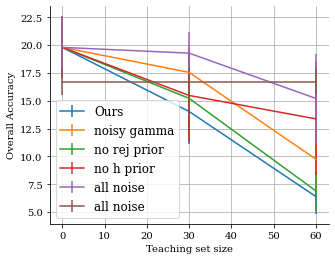

In [ ]:

teaching_sizes = [i*PLOT_INTERVAL for i in range(3)]
actual_max_trials = len(scores_oracle_fixed) 
avgs_rand = [np.average([scores_oracle_fixed[triall] - scores_ours[triall][i] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
stds_rand = [np.std([scores_oracle_fixed[triall] -  scores_ours[triall][i] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
plt.errorbar(teaching_sizes,  avgs_rand, yerr=stds_rand, label=f'Ours')
print(f'no noise {avgs_rand[-1]} and std {stds_rand[-1]} ')
avgs_rand = [np.average([scores_oracle_fixed[triall] -  scores_noisy_gamma[triall][i] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
stds_rand = [np.std([scores_oracle_fixed[triall] -  scores_noisy_gamma[triall][i] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
plt.errorbar(teaching_sizes,  avgs_rand, yerr=stds_rand, label=f'noisy gamma')
print(f'noise {avgs_rand[-1]} and std {stds_rand[-1]} ')

avgs_rand = [np.average([scores_oracle_fixed[triall] -  scores_no_rej_prior[triall][i] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
stds_rand = [np.std([scores_oracle_fixed[triall] -  scores_no_rej_prior[triall][i] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
plt.errorbar(teaching_sizes,  avgs_rand, yerr=stds_rand, label=f'no rej prior')
print(f'no rej prior {avgs_rand[-1]} and std {stds_rand[-1]} ')

avgs_rand = [np.average([scores_oracle_fixed[triall] -  scores_no_h_prior[triall][i] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
stds_rand = [np.std([scores_oracle_fixed[triall] -  scores_no_h_prior[triall][i] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
plt.errorbar(teaching_sizes,  avgs_rand, yerr=stds_rand, label=f'no h prior')
print(f'no h prior {avgs_rand[-1]} and std {stds_rand[-1]} ')

avgs_rand = [np.average([scores_oracle_fixed[triall] -  scores_all_noisy[triall][i] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
stds_rand = [np.std([scores_oracle_fixed[triall] -  scores_all_noisy[triall][i] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
plt.errorbar(teaching_sizes,  avgs_rand, yerr=stds_rand, label=f'all noise')
print(f'all noisy {avgs_rand[-1]} and std {stds_rand[-1]} ')
print(f'prior {avgs_rand[0]} and std {stds_rand[0]} ')



avgs_rand = [np.average([scores_oracle_fixed[triall] -  scores_human[triall] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
stds_rand = [np.std([scores_oracle_fixed[triall] -  scores_human[triall] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
plt.errorbar(teaching_sizes,  avgs_rand, yerr=stds_rand, label=f'all noise')
print(f'human {avgs_rand[-1]} and std {stds_rand[-1]} ')

ax = plt.gca()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()   
plt.grid()
plt.legend(fontsize='large')
plt.ylabel('Overall Accuracy')
plt.xlabel('Teaching set size')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 5
fig_size[1] = 4
plt.savefig("teaching_complexity.pdf", dpi = 1000)
plt.show()

no noise 6.385671752795072 and std 1.557033581182752 
noise 9.744435727652322 and std 3.0204328625623353 
no rej prior 6.896683700398356 and std 1.79775695379866 
no h prior 13.364703469123455 and std 5.070061099430413 
all noisy 15.202427186795349 and std 4.004631766050286 
prior 19.787140012475493 and std 2.7956174284789865 
human 16.721666666666668 and std 1.226463977819521 

In [ ]:
print(f'all noisy {avgs_rand[0]} and std {stds_rand[0]} ')


all noisy 12.598963581402023 and std 1.563611127295768 


# Robustness in missing h

In [ ]:
human_predictor = FakeAI(teaching_embeddings, teaching_embeddings, 15, 15,  (2,1), kmeans = None)
kmeans_pass = human_predictor.kmeans_pass


In [ ]:
REJECT_EPSILON = 0.9
MAX_TRIALS = 10
MAX_SIZE = 30 + 1
PLOT_INTERVAL = 30

In [ ]:
scores_noisy_h = [[] for _ in range(MAX_TRIALS)]
scores_oracle = []
scores_prior = []
scores_no_h_prior = []
for trial in range(MAX_TRIALS):
    # Get Human Predictions
    not_found_good_config = True
    print(f' \n \n trial {trial}  \n \n')
    while not_found_good_config:
        hum_teaching_preds = []
        hum_validation_preds = []
        priorhum_teaching_preds = []
        priorhum_validation_preds = []
        human_predictor = FakeAI(teaching_embeddings, teaching_embeddings, 15, 15,  (2,1), kmeans = kmeans_pass)
        hum_teaching_preds = []
        hum_validation_preds = []
        priorhum_teaching_preds = []
        priorhum_validation_preds = []
        hum_teaching_preds_b = human_predictor.predict_right_wrong(teaching_embeddings, teaching_embeddings)
        hum_validation_preds_b = human_predictor.predict_right_wrong(validation_embeddings, validation_embeddings)
        for i in range(len(hum_teaching_preds_b)):
            if hum_teaching_preds_b[i] == 1:
                hum_teaching_preds.append(train_answers[i])
            else:
                sents = nltk.sent_tokenize(train_raw_passages[i].replace("#$","</br> </br>"))
                rand_sent = random.randint(0,len(sents)-1)
                hum_teaching_preds.append(sents[rand_sent])
        for i in range(len(hum_validation_preds_b)):
            if hum_validation_preds_b[i] == 1:
                hum_validation_preds.append(test_answers[i])
            else:
                sents = nltk.sent_tokenize(test_raw_passages[i].replace("#$","</br> </br>"))
                rand_sent = random.randint(0,len(sents)-1)
                hum_validation_preds.append(sents[rand_sent])
        priorhum_teaching_preds = human_predictor.prior_rejector(teaching_embeddings, teaching_embeddings, REJECT_EPSILON)
        priorhum_validation_preds = human_predictor.prior_rejector(validation_embeddings, validation_embeddings, REJECT_EPSILON)

        # Get AI predictions
        ai_teaching_preds = []
        ai_validation_preds = []
        fakeai = FakeAI(teaching_embeddings, teaching_embeddings, 15, 15, (1,1), kmeans = human_predictor.kmeans_pass )
        ai_teaching_preds_b = fakeai.predict_right_wrong(teaching_embeddings, teaching_embeddings)
        ai_validation_preds_b = fakeai.predict_right_wrong(validation_embeddings, validation_embeddings)
        ai_teaching_preds = []
        for i in range(len(ai_teaching_preds_b)):
            if ai_teaching_preds_b[i] == 1:
                ai_teaching_preds.append(train_answers[i])
            else:
                sents = nltk.sent_tokenize(train_raw_passages[i].replace("#$","</br> </br>"))
                rand_sent = random.randint(0,len(sents)-1)
                ai_teaching_preds.append(sents[rand_sent])
        ai_validation_preds = []
        for i in range(len(ai_validation_preds_b)):
            if ai_validation_preds_b[i] == 1:
                ai_validation_preds.append(test_answers[i])
            else:
                sents = nltk.sent_tokenize(test_raw_passages[i].replace("#$","</br> </br>"))
                rand_sent = random.randint(0,len(sents)-1)
                ai_validation_preds.append(sents[rand_sent])

        # Optimal deferall decisions
        opt_defer_teaching = []
        opt_defer_validation = []
        clusts_p_ai = fakeai.kmeans_pass.predict(teaching_embeddings)
        clusts_p_hum = human_predictor.kmeans_pass.predict(teaching_embeddings)
        for ex in range(len(hum_teaching_preds)):
            corr_ai = fakeai.clust_err_p[clusts_p_ai[ex]]
            corr_hum = human_predictor.clust_err_p[clusts_p_hum[ex]]
            if corr_ai >= corr_hum:
                opt_defer_teaching.append(1)
            else:
                opt_defer_teaching.append(0)
        clusts_p_ai = fakeai.kmeans_pass.predict(validation_embeddings)
        clusts_p_hum = human_predictor.kmeans_pass.predict(validation_embeddings)
        for ex in range(len(hum_validation_preds)):
            corr_ai = fakeai.clust_err_p[clusts_p_ai[ex]]
            corr_hum = human_predictor.clust_err_p[clusts_p_hum[ex]]
            if corr_ai >= corr_hum:
                opt_defer_validation.append(1)
            else:
                opt_defer_validation.append(0)

        optimal_gammas = [1.0]*len(teaching_embeddings)
        
        optimal_score = compute_metrics(hum_validation_preds, ai_validation_preds, opt_defer_validation, test_answers)
        print(optimal_score)
        prior_score = compute_metrics(hum_validation_preds, ai_validation_preds, priorhum_validation_preds, test_answers)
        prior_score = prior_score[1]['exact_match']
        human_score = compute_metrics(hum_validation_preds, ai_validation_preds, [0]*len(ai_validation_preds), test_answers)
        hum = human_score[1]['exact_match']
        opt = optimal_score[1]['exact_match']
        print(opt-hum)
        print(opt-prior_score)
        if (opt - hum) >= 15 and (opt - prior_score) >= 15:
            not_found_good_config = False
            print("human score is " + str(human_score[1]['exact_match']))
            print(optimal_score)

        else:
            print("trying again")
    scores_prior.append(prior_score)
    scores_oracle.append(optimal_score[1]['exact_match'])

    random_preds = np.random.randint(2, size = len(priorhum_teaching_preds))
    opt_err_defer_teaching = []
    clusts_p_ai = fakeai.kmeans_pass.predict(teaching_embeddings)
    #clusts_p_hum = human_err_predictor.kmeans_pass.predict(teaching_embeddings)
    for ex in range(len(hum_teaching_preds)):
        corr_ai = fakeai.clust_err_p[clusts_p_ai[ex]]
        corr_hum = 0.5
        if corr_ai >= corr_hum:
            opt_err_defer_teaching.append(1)
        else:
            opt_err_defer_teaching.append(0) 

    print("running with binary h")
    errors, indices_used = teach_ours_doublegreedy(random_preds, priorhum_teaching_preds, opt_err_defer_teaching, False)
    scores_no_h_prior.append(errors)

    clust_err_p = human_predictor.clust_err_p
    for delta in range(0,11):
        print(" \n ################")
        print("Adding noise " +str(delta/20))
        print("  ################ \n")
        # add noise 
        new_clust_err_p = []
        for clust in range(len(clust_err_p)):
            rand_sign = 2*np.random.randint(2) - 1
            new_clust = clust_err_p[clust] + rand_sign*delta/20
            if new_clust >= 1:
                new_clust = 1
            elif new_clust <= 0:
                new_clust = 0
            new_clust_err_p.append(new_clust)
        human_err_predictor = FakeAI(teaching_embeddings, teaching_embeddings, 15, 15,  (2,1), kmeans_pass, new_clust_err_p)
        opt_err_defer_teaching = []
        clusts_p_ai = fakeai.kmeans_pass.predict(teaching_embeddings)
        clusts_p_hum = human_err_predictor.kmeans_pass.predict(teaching_embeddings)
        for ex in range(len(hum_teaching_preds)):
            corr_ai = fakeai.clust_err_p[clusts_p_ai[ex]]
            corr_hum = human_err_predictor.clust_err_p[clusts_p_hum[ex]]
            if corr_ai >= corr_hum:
                opt_err_defer_teaching.append(1)
            else:
                opt_err_defer_teaching.append(0) 
        hum_err_teaching_preds_b = human_err_predictor.predict_right_wrong(teaching_embeddings, teaching_embeddings)
        errors, indices_used = teach_ours_doublegreedy(hum_err_teaching_preds_b, priorhum_teaching_preds, opt_err_defer_teaching, False)
        scores_noisy_h[trial].append(errors[-1])


Streaming output truncated to the last 5000 lines.
got improvements with max 156
New size 27
got improvements with max 175
New size 28
got improvements with max 135
New size 29
got improvements with max 123
New size 30
got improvements with max 137
####### val eval 30 ###########
Coverage is 43.07
 metrics of system are: {'exact_match': 73.62890456312067, 'f1': 75.32864253156187}
 metrics of human are: {'exact_match': 77.30614973262006, 'f1': 78.70033460718483}
 metrics of AI are: {'exact_match': 70.8470290771174, 'f1': 72.77792124451643}
##############################
 
 ################
Adding noise 0.35
  ################ 

New size 0
got improvements with max 1077
####### val eval 0 ###########
Coverage is 37.58
 metrics of system are: {'exact_match': 73.80164099611332, 'f1': 75.50975356821387}
 metrics of human are: {'exact_match': 83.22481807736467, 'f1': 84.18438540514843}
 metrics of AI are: {'exact_match': 68.12730627306257, 'f1': 70.28616876050236}
###########################

KeyboardInterrupt: ignored

In [ ]:
print(scores_noisy_h)
print(scores_oracle)
print(scores_prior)
print(scores_no_h_prior)

NameError: ignored

In [ ]:
len(scores_no_h_prior)

7

In [ ]:
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal fonts-adf-accanthis fonts-adf-berenis fonts-adf-gillius
  fonts-adf-universalis fonts-cabin fonts-comfortaa fonts-croscore
  fonts-crosextra-caladea fonts-crosextra-carlito fonts-dejavu-core
  fonts-dejavu-extra fonts-droid-fallback fonts-ebgaramond
  fonts-ebgaramond-extra fonts-font-awesome fonts-freefont-otf
  fonts-freefont-ttf fonts-gfs-artemisia fonts-gfs-complutum fonts-gfs-didot
  fonts-gfs-neohellenic fonts-gfs-olga fonts-gfs-solomos fonts-go
  fonts-junicode fonts-lato fonts-linuxlibertine fonts-lmodern fonts-lobster
  fonts-lobstertwo fonts-noto-hinted fonts-noto-mono fonts-oflb-asana-math
  fonts-open-sans fonts-roboto-hinted fonts-sil-gentium
  fonts-sil-gentium-basic fonts-s

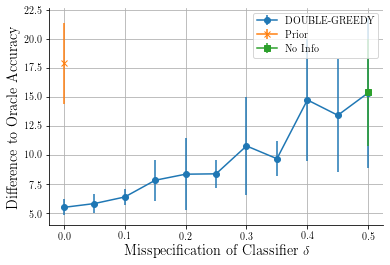

In [ ]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
teaching_sizes = [i/20 for i in range(11)]
actual_max_trials = len(scores_no_h_prior) 

avgs_rand = [np.average([ scores_oracle[triall] - scores_noisy_h[triall][i] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
stds_rand = [np.std([scores_oracle[triall] - scores_noisy_h[triall][i] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
plt.errorbar(teaching_sizes,  avgs_rand, yerr=stds_rand, marker = "o",  label=f'DOUBLE-GREEDY')

avgs_rand = [np.average([ scores_oracle[triall] - scores_prior[triall] for triall in range(actual_max_trials)]) for i in range(1)]
stds_rand = [np.std([scores_oracle[triall] - scores_prior[triall] for triall in range(actual_max_trials)]) for i in range(1)]
plt.errorbar([0],  avgs_rand, yerr=stds_rand, marker = "x",  label=f'Prior')

avgs_rand = [np.average([ scores_oracle[triall] - scores_no_h_prior[triall][-1] for triall in range(actual_max_trials)]) for i in range(1)]
stds_rand = [np.std([scores_oracle[triall] - scores_no_h_prior[triall][-1] for triall in range(actual_max_trials)]) for i in range(1)]
plt.errorbar([0.5],  avgs_rand, yerr=stds_rand, marker = "s",  label=f'No Info')


'''
plt.errorbar(teaching_sizes,  errors[:len(teaching_sizes)],  label=f'Ours')
plt.errorbar(teaching_sizes,  errors_medoid[:len(teaching_sizes)],  label=f'Medoids')
plt.errorbar(teaching_sizes,  errors_random[:len(teaching_sizes)],  label=f'Random')
plt.errorbar(teaching_sizes,  errors_lime[:len(teaching_sizes)],  label=f'Lime')
'''

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()   
plt.grid()
plt.legend(fontsize='large')
plt.legend()
plt.ylabel('Difference to Oracle Accuracy',  fontsize='x-large')
plt.xlabel('Misspecification of Classifier $\delta$', fontsize='x-large')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 4
plt.savefig("noise_in_h.pdf", dpi = 1000)
plt.show()